In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import numpy as np
import pandas as pd

In [103]:
train_folder = 'data/train_/'
test_folder = 'data/test_/'
data_folder = 'data/'
random_subset = 10

In [104]:
files = !ls {train_folder}
files = np.array(files)
n = len(files)

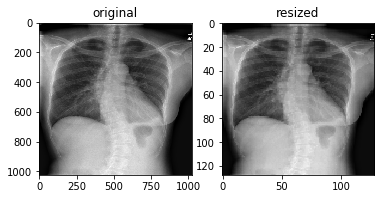

In [105]:
img = cv2.imread(f'{train_folder}{files[10]}',1)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original')
img2 = cv2.resize(img,(128,128))
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('resized')

In [106]:
idx = np.random.choice(n,size=(random_subset,),replace=False)
for i, _ in enumerate(files[idx]):
    img = cv2.imread(f'{train_folder}{files[i]}',1)
    # all channels are same
    assert (np.logical_and( (img[:,:,0]==img[:,:,1]).all(), (img[:,:,1]==img[:,:,2]).all()) == True )

In [107]:
labels_tr = pd.read_csv(f'{data_folder}train.csv')
labels_tr.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [108]:
labels_tr.isnull().values.any() #no null values

False

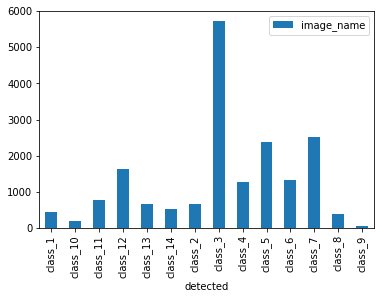

In [109]:
classes = pd.Series(['class_1','class_2', 'class_3', 'class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13','class_14',])
labels_tr.groupby('detected').count().reset_index().plot(kind='bar', x='detected',y='image_name')

In [110]:
rdc = labels_tr.groupby(['gender','detected']).count()


In [111]:
F = rdc.loc['F']
M = rdc.loc['M']
M

,row_id,age,view_position,image_name
detected,,,,
class_1,240,240,240,240
class_10,119,119,119,119
class_11,464,464,464,464
class_12,921,921,921,921
class_13,388,388,388,388
class_14,335,335,335,335
class_2,306,306,306,306
class_3,3230,3230,3230,3230
class_4,776,776,776,776


In [112]:
(M.index == F.index).any()

True

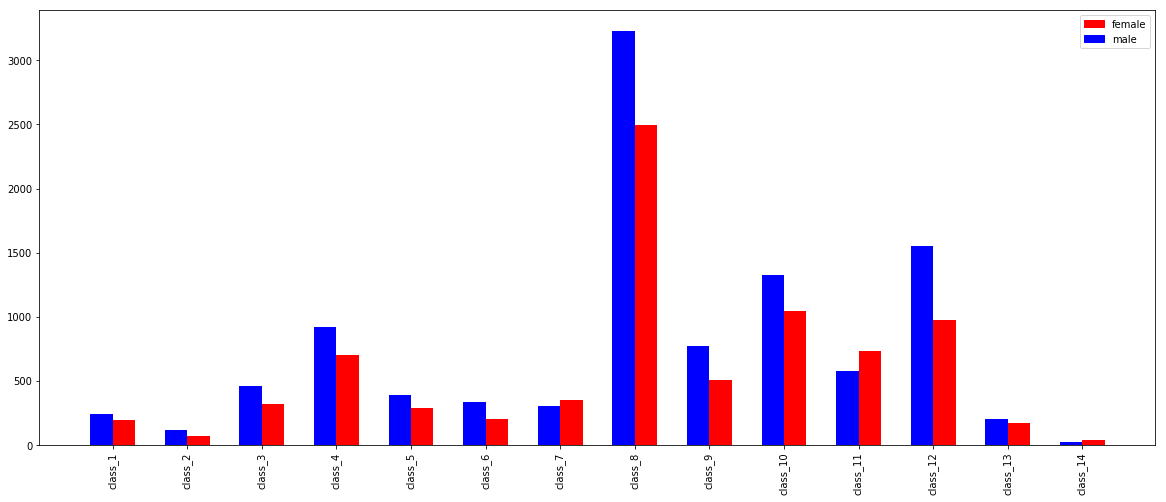

In [113]:
plt.figure(figsize = (20,8))
red_patch = mpatches.Patch(color='red', label='female')
blue_patch = mpatches.Patch(color='blue', label='male')
ax = plt.subplot(111)
plt.xticks(np.arange(len(classes)), classes, rotation=90)
ax.bar(np.arange(len(classes)) - 0.3, M['age'],width=0.3,color='b',align='edge')
ax.bar(np.arange(len(classes)), F['age'],width=0.3,color='r',align='edge')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

In [114]:
files = labels_tr['image_name']
files[:10]

0        scan_0000.png
1        scan_0001.png
2       scan_00010.png
3     scan_0001000.png
4    scan_00010000.png
5    scan_00010001.png
6    scan_00010003.png
7    scan_00010004.png
8    scan_00010006.png
9    scan_00010007.png
Name: image_name, dtype: object

In [115]:
labels_tr.set_index('image_name').head()

,row_id,age,gender,view_position,detected
image_name,,,,,
scan_0000.png,id_0,45,M,0,class_3
scan_0001.png,id_1,57,F,0,class_3
scan_00010.png,id_10,58,M,0,class_3
scan_0001000.png,id_1000,64,M,0,class_6
scan_00010000.png,id_10000,33,M,1,class_3


In [134]:
def show_sample(img,label,mapping):
    plt.imshow(img)
    plt.title("label={} and class_name={}".format(label,mapping[label]))

In [118]:
t = labels_tr
t.head()
# t['codes'] = t.detected.astype('category')
# for i in 
# t['codes'] = t.detected
dict(enumerate(t.detected.astype('category').cat.categories))


{0: 'class_1',
 1: 'class_10',
 2: 'class_11',
 3: 'class_12',
 4: 'class_13',
 5: 'class_14',
 6: 'class_2',
 7: 'class_3',
 8: 'class_4',
 9: 'class_5',
 10: 'class_6',
 11: 'class_7',
 12: 'class_8',
 13: 'class_9'}

## Data Loading and Transformations

In [80]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os

In [81]:
os.path.join('a','b','c')

'a/b/c'

In [143]:
class XRayDataset(Dataset):
    
    def __init__(self, csv_file, path, transform = None):
        self.df = pd.read_csv(csv_file)
        self.df['detected_id'] = self.df.detected.astype('category').cat.codes
        self.path = path
        self.idx_to_classes = dict(enumerate(self.df.detected.astype('category').cat.categories))
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,idx):
        img_path = os.path.join(self.path,'train_',self.df.loc[idx,'image_name'])
        img = cv2.imread(img_path,1)
        label = self.df.loc[idx,'detected_id']
        sample = {'image':img,
                  'label':label
                 }
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample      


0 (1024, 1024, 3) 7
1 (1024, 1024, 3) 7
2 (1024, 1024, 3) 7
3 (1024, 1024, 3) 10


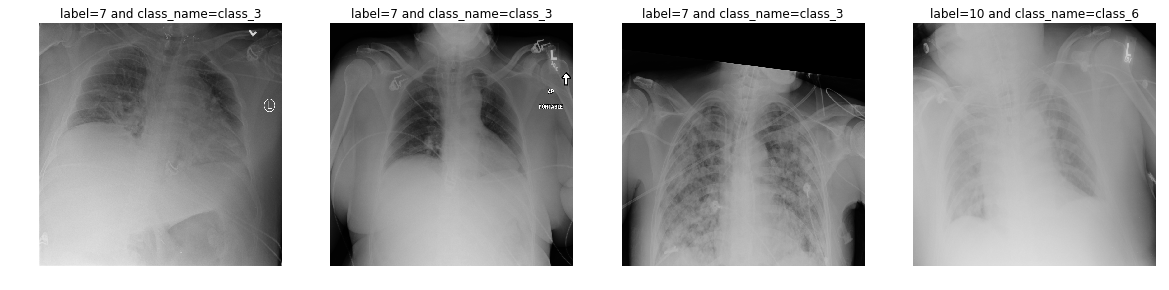

In [148]:
train_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',None)

fig = plt.figure(figsize=(20,5))

for i in range(len(dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_sample(sample['image'],sample['label'],dataset.idx_to_classes)

    if i == 3:
        plt.show()
        break


In [149]:
class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_h, new_w))

        return {'image': img, 'label': label}


class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'label': label}


class ToTensor(object):

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

In [ ]:
tfms = {
    'train':transforms.Compose([
        transforms.Resize((227,227))
        transforms.Normalize()
    ])
}